# The Valuation Gap: Where Do High-Leverage Relievers Really Stand?

High-leverage relievers sit in a valuation gap between baseball's two primary value metrics. Using Fangraphs pitcher data from 2016–2025, this analysis shows that **WAR systematically undervalues** elite relievers while **WPA systematically overvalues** them — and the truth lies somewhere in between.

**Key Metrics**:
- **WAR** (Wins Above Replacement): Measures pitcher value via performance (ERA/FIP) × volume (IP). Isolates underlying skill but **ignores leverage**, treating all innings as equally important.
- **WPA** (Win Probability Added): Measures actual impact on win probability, fully incorporating timing and context. But it also absorbs **managerial usage patterns, sequencing luck, and situational noise** that the pitcher doesn't control.
- **LI** (Leverage Index): Quantifies the importance of the game situation when a pitcher enters. Crucially, leverage is determined by game flow and managerial deployment — not by the reliever himself.

**The Core Tension**: WAR says high-leverage relievers are barely worth noticing. WPA says they're the most impactful pitchers in baseball. Neither is fully right. Every team generates a large number of high-leverage moments over a season, and elite relief skill reliably converts those moments into real wins — but raw WPA overstates the pitcher's individual contribution by conflating skill with opportunity.

## 1. Load & Classify Pitcher Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.express as px
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Georgia', 'Cambria']

# --- Data Loading ---
from pybaseball import pitching_stats

START_YEAR = 2016
END_YEAR = 2025
QUAL = 5
CSV_PATH = f'fangraphs_pitchers_{START_YEAR}_{END_YEAR}_IP{QUAL}.csv'

if os.path.exists(CSV_PATH):
    print(f"Loading cached data from {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print("Fetching pitcher data from Fangraphs...")
    df = pitching_stats(start_season=START_YEAR, end_season=END_YEAR, qual=QUAL)
    df.to_csv(CSV_PATH, index=False)
    print(f"Saved data to {CSV_PATH}")

# Rename columns
rename_map = {
    'Name': 'Player', 'K%': 'Strikeout_Rate', 'BB%': 'Walk_Rate',
    'pLI': 'LI', 'WPA/LI': 'WPA_LI', 'SO': 'Strikeouts', 'BB': 'Walks',
    'G': 'Games', 'GS': 'Games_Started', 'FIP': 'FIP', 'ERA': 'ERA',
    'WAR': 'WAR', 'WPA': 'WPA', 'WHIP': 'WHIP'
}
df = df.rename(columns=rename_map)

# Classify: SP (>=5 GS, >=20 IP) vs RP (>=5 G, <3 GS)
def classify_pitcher(row):
    if row.get('Games_Started', 0) >= 5 and row.get('IP', 0) >= 20:
        return 'SP'
    elif row.get('Games', 0) >= 5 and row.get('Games_Started', 0) < 3:
        return 'RP'
    return 'Other'

df['Pitcher_Type'] = df.apply(classify_pitcher, axis=1)
df = df[df['Pitcher_Type'].isin(['SP', 'RP'])].reset_index(drop=True)

for col in ['IP', 'LI', 'FIP', 'ERA', 'WAR', 'WPA', 'WHIP', 'Games', 'Games_Started']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Loaded {len(df)} pitcher-seasons ({START_YEAR}\u2013{END_YEAR})")
print(f"  SP seasons: {(df['Pitcher_Type'] == 'SP').sum()}")
print(f"  RP seasons: {(df['Pitcher_Type'] == 'RP').sum()}")

Loading cached data from fangraphs_pitchers_2016_2025_IP5.csv
Loaded 6314 pitcher-seasons (2016–2025)
  SP seasons: 2337
  RP seasons: 3977


## 2. Aggregate & Identify High-Leverage Relievers

We aggregate each pitcher's career totals across all seasons, then use **k-means clustering (k=3)** on average Leverage Index to separate relievers into three tiers: High, Medium, and Low leverage. The scatter plot below shows the resulting clusters — each dot is one reliever's aggregated career, positioned by total innings pitched and average leverage.

In [2]:
# Aggregate by pitcher
agg_dict = {
    'IP': 'sum', 'WPA': 'sum', 'WAR': 'sum', 'Games': 'sum', 'Games_Started': 'sum',
    'ERA': 'mean', 'FIP': 'mean', 'WHIP': 'mean', 'LI': 'mean',
    'Pitcher_Type': 'first', 'Season': 'count'
}
df_agg = df.groupby('Player').agg(agg_dict).reset_index()
df_agg.rename(columns={'Season': 'Seasons'}, inplace=True)

# Cluster relievers by leverage
rp_df = df_agg[df_agg['Pitcher_Type'] == 'RP'].copy().dropna(subset=['IP', 'LI'])
kmeans = KMeans(n_clusters=3, random_state=42)
rp_df['Leverage_Cluster'] = kmeans.fit_predict(rp_df[['LI']].values)

cluster_means = rp_df.groupby('Leverage_Cluster')['LI'].mean()
high_leverage_cluster = cluster_means.idxmax()
rp_df['High_Leverage'] = rp_df['Leverage_Cluster'] == high_leverage_cluster

# Build comparison groups
sp_df = df_agg[df_agg['Pitcher_Type'] == 'SP'].copy()
high_lev_rp_df = rp_df[rp_df['High_Leverage']].copy()
high_lev_rp_df['Pitcher_Type'] = 'RP (High Lev)'

comparison_df = pd.concat([sp_df, high_lev_rp_df], ignore_index=True)
comparison_df = comparison_df.dropna(subset=['ERA', 'IP', 'LI'])

print(f"\nAggregated pitchers: {len(df_agg)} total")
print(f"  SPs: {len(sp_df)}")
print(f"  All RPs: {len(rp_df)}")
print(f"  High-Leverage RPs: {len(high_lev_rp_df)} (avg LI: {high_lev_rp_df['LI'].mean():.2f})")


Aggregated pitchers: 1860 total
  SPs: 665
  All RPs: 1195
  High-Leverage RPs: 272 (avg LI: 1.34)


In [11]:
# Visualize the 3 leverage clusters
cluster_li = rp_df.groupby('Leverage_Cluster')['LI'].mean().sort_values()
cluster_order = list(cluster_li.index)
cluster_labels = {cluster_order[0]: 'Low Leverage', cluster_order[1]: 'Medium Leverage', cluster_order[2]: 'High Leverage'}
cluster_colors = {cluster_order[0]: '#BCBD22', cluster_order[1]: '#FF7F0E', cluster_order[2]: '#D62728'}

fig_cl = px.scatter(
    rp_df,
    x='IP', y='LI',
    color=rp_df['Leverage_Cluster'].map(cluster_labels),
    color_discrete_map={'Low Leverage': '#BCBD22', 'Medium Leverage': '#FF7F0E', 'High Leverage': '#D62728'},
    hover_data=['Player', 'ERA', 'WAR', 'LI', 'IP', 'Seasons'],
    labels={'IP': 'Innings Pitched (IP)', 'LI': 'Average Leverage Index (LI)', 'color': 'Cluster'},
    title=f'K-Means Clustering of Relievers by Leverage Index<br><sup>k = 3, {START_YEAR}\u2013{END_YEAR}</sup>'
)
fig_cl.update_traces(marker=dict(size=8, opacity=0.4))
fig_cl.update_layout(
    font_family='Georgia, Times New Roman, serif',
    height=550, width=900,
    legend_title_text='Leverage Tier',
    hoverlabel=dict(font_family='Georgia, Times New Roman, serif'),
    title_x=0.5,
    title_font_size=20,
)
fig_cl.for_each_trace(lambda t: t.update(
    hovertemplate=t.hovertemplate.replace('=', ' = ') if t.hovertemplate else t.hovertemplate
))
fig_cl.show()

for label, cluster_id in [(l, c) for c, l in cluster_labels.items()]:
    n = (rp_df['Leverage_Cluster'] == cluster_id).sum()

    avg_li = rp_df[rp_df['Leverage_Cluster'] == cluster_id]['LI'].mean()
    print(f"  {label}: {n} pitchers (avg LI: {avg_li:.2f})")

  Low Leverage: 317 pitchers (avg LI: 0.36)
  Medium Leverage: 606 pitchers (avg LI: 0.80)
  High Leverage: 272 pitchers (avg LI: 1.34)


## 3. The Divergence: SPs vs High-Leverage RPs

The charts below reveal the valuation gap in stark terms. By WPA, high-leverage relievers outproduce all starting pitchers combined. By WAR, they're worth a fraction. Neither extreme reflects reality — WAR ignores that these innings matter more, while WPA inflates them with sequencing and managerial context the pitcher doesn't control. The true value of high-leverage relievers is **higher than WAR suggests, but substantially lower than raw WPA implies**.

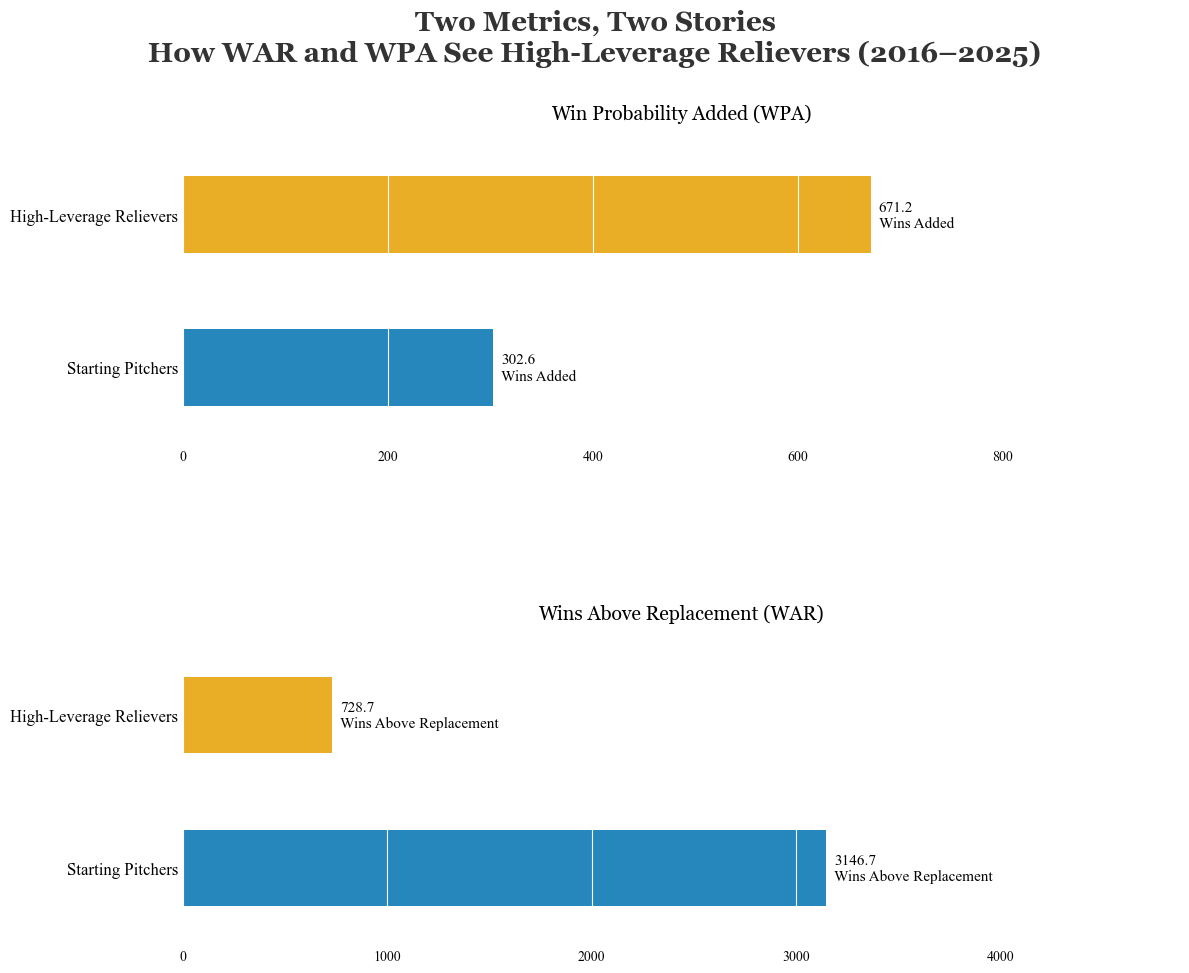

In [27]:
# WPA & WAR Comparison: SPs vs High-Leverage RPs
comparison_wpa = comparison_df.dropna(subset=['WPA'])
comparison_war = comparison_df.dropna(subset=['WAR'])

sp_total_wpa = comparison_wpa[comparison_wpa['Pitcher_Type'] == 'SP']['WPA'].sum()
rp_total_wpa = comparison_wpa[comparison_wpa['Pitcher_Type'] == 'RP (High Lev)']['WPA'].sum()
sp_total_war = comparison_war[comparison_war['Pitcher_Type'] == 'SP']['WAR'].sum()
rp_total_war = comparison_war[comparison_war['Pitcher_Type'] == 'RP (High Lev)']['WAR'].sum()

fig, axes = plt.subplots(2, 1, figsize=(12, 9.5))
categories = ['Starting Pitchers', 'High-Leverage Relievers']
colors = ['#0072B2', '#E69F00']
bar_h = 0.35
y_pos = [0, bar_h * 2]

fig.suptitle(f'Two Metrics, Two Stories\nHow WAR and WPA See High-Leverage Relievers ({START_YEAR}\u2013{END_YEAR})',
             fontsize=20, fontweight='bold', fontname='Georgia', color='#333333', y=1.02)

# WPA subplot
ax1 = axes[0]
wpa_values = [sp_total_wpa, rp_total_wpa]
bars1 = ax1.barh(y_pos, wpa_values, color=colors, alpha=0.85, height=bar_h, zorder=2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(categories)
for bar, val in zip(bars1, wpa_values):
    ax1.text(bar.get_width() + 8, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}\nWins Added', va='center', ha='left', fontsize=11, fontweight='normal', fontname='serif', linespacing=1.2)
ax1.set_title('Win Probability Added (WPA)', fontsize=14, fontweight='normal', fontname='Georgia', pad=2)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.set_axisbelow(False)
ax1.xaxis.grid(True, color='white', linewidth=0.8, zorder=3)
ax1.yaxis.grid(False)
ax1.tick_params(axis='x', length=0); ax1.tick_params(axis='y', length=0, labelsize=12)
for spine in ax1.spines.values(): spine.set_visible(False)
ax1.set_xlim(0, max(wpa_values) * 1.45)
ax1.set_ylim(-bar_h, y_pos[-1] + bar_h * 1.2)

# WAR subplot
ax2 = axes[1]
war_values = [sp_total_war, rp_total_war]
bars2 = ax2.barh(y_pos, war_values, color=colors, alpha=0.85, height=bar_h, zorder=2)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(categories)
for bar, val in zip(bars2, war_values):
    ax2.text(bar.get_width() + 40, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}\nWins Above Replacement', va='center', ha='left', fontsize=11, fontweight='normal', fontname='serif', linespacing=1.2)
ax2.set_title('Wins Above Replacement (WAR)', fontsize=14, fontweight='normal', fontname='Georgia', pad=2)
ax2.xaxis.set_major_locator(mticker.AutoLocator())
ax2.set_axisbelow(False)
ax2.xaxis.grid(True, color='white', linewidth=0.8, zorder=3)
ax2.yaxis.grid(False)
ax2.tick_params(axis='x', length=0); ax2.tick_params(axis='y', length=0, labelsize=12)
for spine in ax2.spines.values(): spine.set_visible(False)
ax2.set_xlim(0, max(war_values) * 1.55)
ax2.set_ylim(-bar_h, y_pos[-1] + bar_h * 1.2)

plt.tight_layout(h_pad=10)
plt.subplots_adjust(top=0.90)
plt.show()

wpa_ratio = (rp_total_wpa / sp_total_wpa) * 100
war_ratio = (rp_total_war / sp_total_war) * 100

## 4. Individual Season Scatter: WPA vs WAR

Each dot is a single pitcher-season. SPs spread horizontally (high WAR, moderate WPA) — their volume drives skill-based value but dilutes game-context impact. High-leverage RPs spread vertically (low WAR, wide WPA range) — their value is concentrated in high-stakes moments but inflated by sequencing and managerial deployment. The gap between the two clusters is the valuation no-man's-land where neither metric tells the full story.

In [12]:
# Interactive Scatter: WPA vs WAR — Individual Seasons (SPs vs High-Leverage RPs)
hl_rp_names = high_lev_rp_df['Player'].unique()

scatter_df = df[['Player', 'Pitcher_Type', 'Season', 'WAR', 'WPA', 'ERA', 'IP', 'LI']].dropna(subset=['WAR', 'WPA']).copy()
scatter_df = scatter_df[
    (scatter_df['Pitcher_Type'] == 'SP') | 
    ((scatter_df['Pitcher_Type'] == 'RP') & (scatter_df['Player'].isin(hl_rp_names)))
].copy()
scatter_df['Pitcher_Type'] = scatter_df['Pitcher_Type'].replace({'RP': 'RP (High Lev)'})

for col in ['WAR', 'WPA', 'ERA', 'IP', 'LI']:
    scatter_df[col] = scatter_df[col].round(2)

fig4 = px.scatter(
    scatter_df, x='WAR', y='WPA', color='Pitcher_Type',
    hover_data=['Player', 'Season', 'ERA', 'IP', 'LI', 'WAR', 'WPA'],
    labels={'WAR': 'Wins Above Replacement (WAR)', 'WPA': 'Win Probability Added (WPA)'},
    title=f'WPA vs WAR: Starting Pitchers vs High-Leverage Relievers<br><sup>Individual Pitcher-Seasons, {START_YEAR}\u2013{END_YEAR}</sup>',
    color_discrete_map={'SP': '#0072B2', 'RP (High Lev)': '#E69F00'}
)
fig4.update_traces(marker=dict(size=4, opacity=0.5))
fig4.update_layout(
    font_family='Georgia, Times New Roman, serif',
    height=650, width=950,
    hoverlabel=dict(font_family='Georgia, Times New Roman, serif'),
    xaxis_title_font_family='Georgia, Times New Roman, serif',
    yaxis_title_font_family='Georgia, Times New Roman, serif',
    title_x=0.5,
    title_font_size=20,
)
fig4.for_each_trace(lambda t: t.update(
    hovertemplate=t.hovertemplate.replace('=', ' = ') if t.hovertemplate else t.hovertemplate

))
fig4.show()

## Conclusion

High-leverage relievers sit in a valuation gap because WAR and WPA measure fundamentally different things:

- **WAR** is designed to credit total volume of performance and isolate underlying skill. This leads it to systematically **undervalue** relievers by treating all innings as equally important and ignoring leverage.

- **WPA** measures who actually swings game outcomes, fully incorporating timing and context. This causes it to systematically **overvalue** relievers by absorbing managerial usage, sequencing, and luck.Any serious evaluation of pitcher value must grapple with this gap. WAR is not wrong, and WPA is not wrong — but used alone, each tells an incomplete and misleading story.



Leverage itself is not controlled by relievers — it is determined by game flow and managerial deployment. Yet every team generates a large number of high-leverage moments over a season, meaning elite relief skill reliably translates into real wins.The true value of high-leverage relievers lies **between the implications of WAR and WPA**: higher than WAR suggests, but substantially lower than raw WPA implies. They play an outsized role in converting win probability into actual victories — without overstating their underlying contribution to total run prevention.
